In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "../data/071825_IF_scan"
if_data_files = ["Cell.csv"]

columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]

column_to_stain = dict(zip(range(1,13), ["pSTAT"]*6 + ["tSTAT"] * 6))

row_to_patient = {
	"B":626,
	"C":617,
	"D":617,
}	
"""
	"E":758,
    "F":451,
    "G":451,
    "H":4510
}
"""

column_to_t_pts = {
	1:"0",
    2:"0",
	3:"20",
	4:"40",
	5:"60",
	6:"90",
	7:"0",
    8:"0",
	9:"20",
	10:"40",
	11:"60",
	12:"90"
}

row_to_replicate = {
    "B":1,
    "C":1,
    "D":2,
   # "E":2,
   # "F":1,
   # "G":2,
   # "H":1    
}


In [ ]:
dfs = []
for fname in if_data_files:
	full_fname = f"{data_dir}/{fname}"
	df = pd.read_csv(full_fname, usecols=columns)

	stat1_means = df.groupby("WellId")["CircTotalIntenCh2"].mean()
	stat1_sems = df.groupby("WellId")["CircTotalIntenCh2"].sem()
	stat3_means = df.groupby("WellId")["CircTotalIntenCh3"].mean()
	stat3_sems = df.groupby("WellId")["CircTotalIntenCh3"].sem()

	stat_df = pd.concat([stat1_means, stat1_sems, stat3_means, stat3_sems], axis=1)
	stat_df.columns = ["STAT1 Mean", "STAT1 SEM", "STAT3 Mean", "STAT3 SEM"]

	# Assign various characteristics based on wells using the dictionaries above
	rows = [x.strip()[0] for x in stat_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_df.index.values]
	stat_df["STAT"] = [column_to_stain[x] for x in cols]
	stat_df["PatientId"] = [row_to_patient[x] for x in rows]
	stat_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_df["Time"] = [column_to_t_pts[x] for x in cols]
	stat_df["Replicate"] = [row_to_replicate[x] for x in rows]
	display(stat_df)
	dfs.append(stat_df)

,STAT1 Mean,STAT1 SEM,STAT3 Mean,STAT3 SEM,STAT,PatientId,IL-6 Concentration,Time,Replicate
WellId,,,,,,,,,
B01,1.058065e+06,12734.927013,8.299732e+05,12695.808423,pSTAT,626,10 ng/mL,0,1
B02,1.159178e+06,14943.926306,9.098966e+05,19318.212867,pSTAT,626,10 ng/mL,0,1
B03,2.211015e+06,53556.565680,5.386722e+06,151120.616491,pSTAT,626,10 ng/mL,20,1
B04,1.714953e+06,35232.018173,3.551792e+06,102501.501470,pSTAT,626,10 ng/mL,40,1
B05,1.255937e+06,17780.854209,1.582311e+06,36871.608627,pSTAT,626,10 ng/mL,60,1
B06,1.187623e+06,15088.418338,1.189389e+06,21196.786175,pSTAT,626,10 ng/mL,90,1
B07,6.171076e+06,171874.090803,5.682727e+06,145255.136233,tSTAT,626,10 ng/mL,0,1
B08,4.995838e+06,209429.842861,4.622577e+06,187370.586131,tSTAT,626,10 ng/mL,0,1
B09,6.397327e+06,191294.532287,1.079533e+07,338871.458887,tSTAT,626,10 ng/mL,20,1


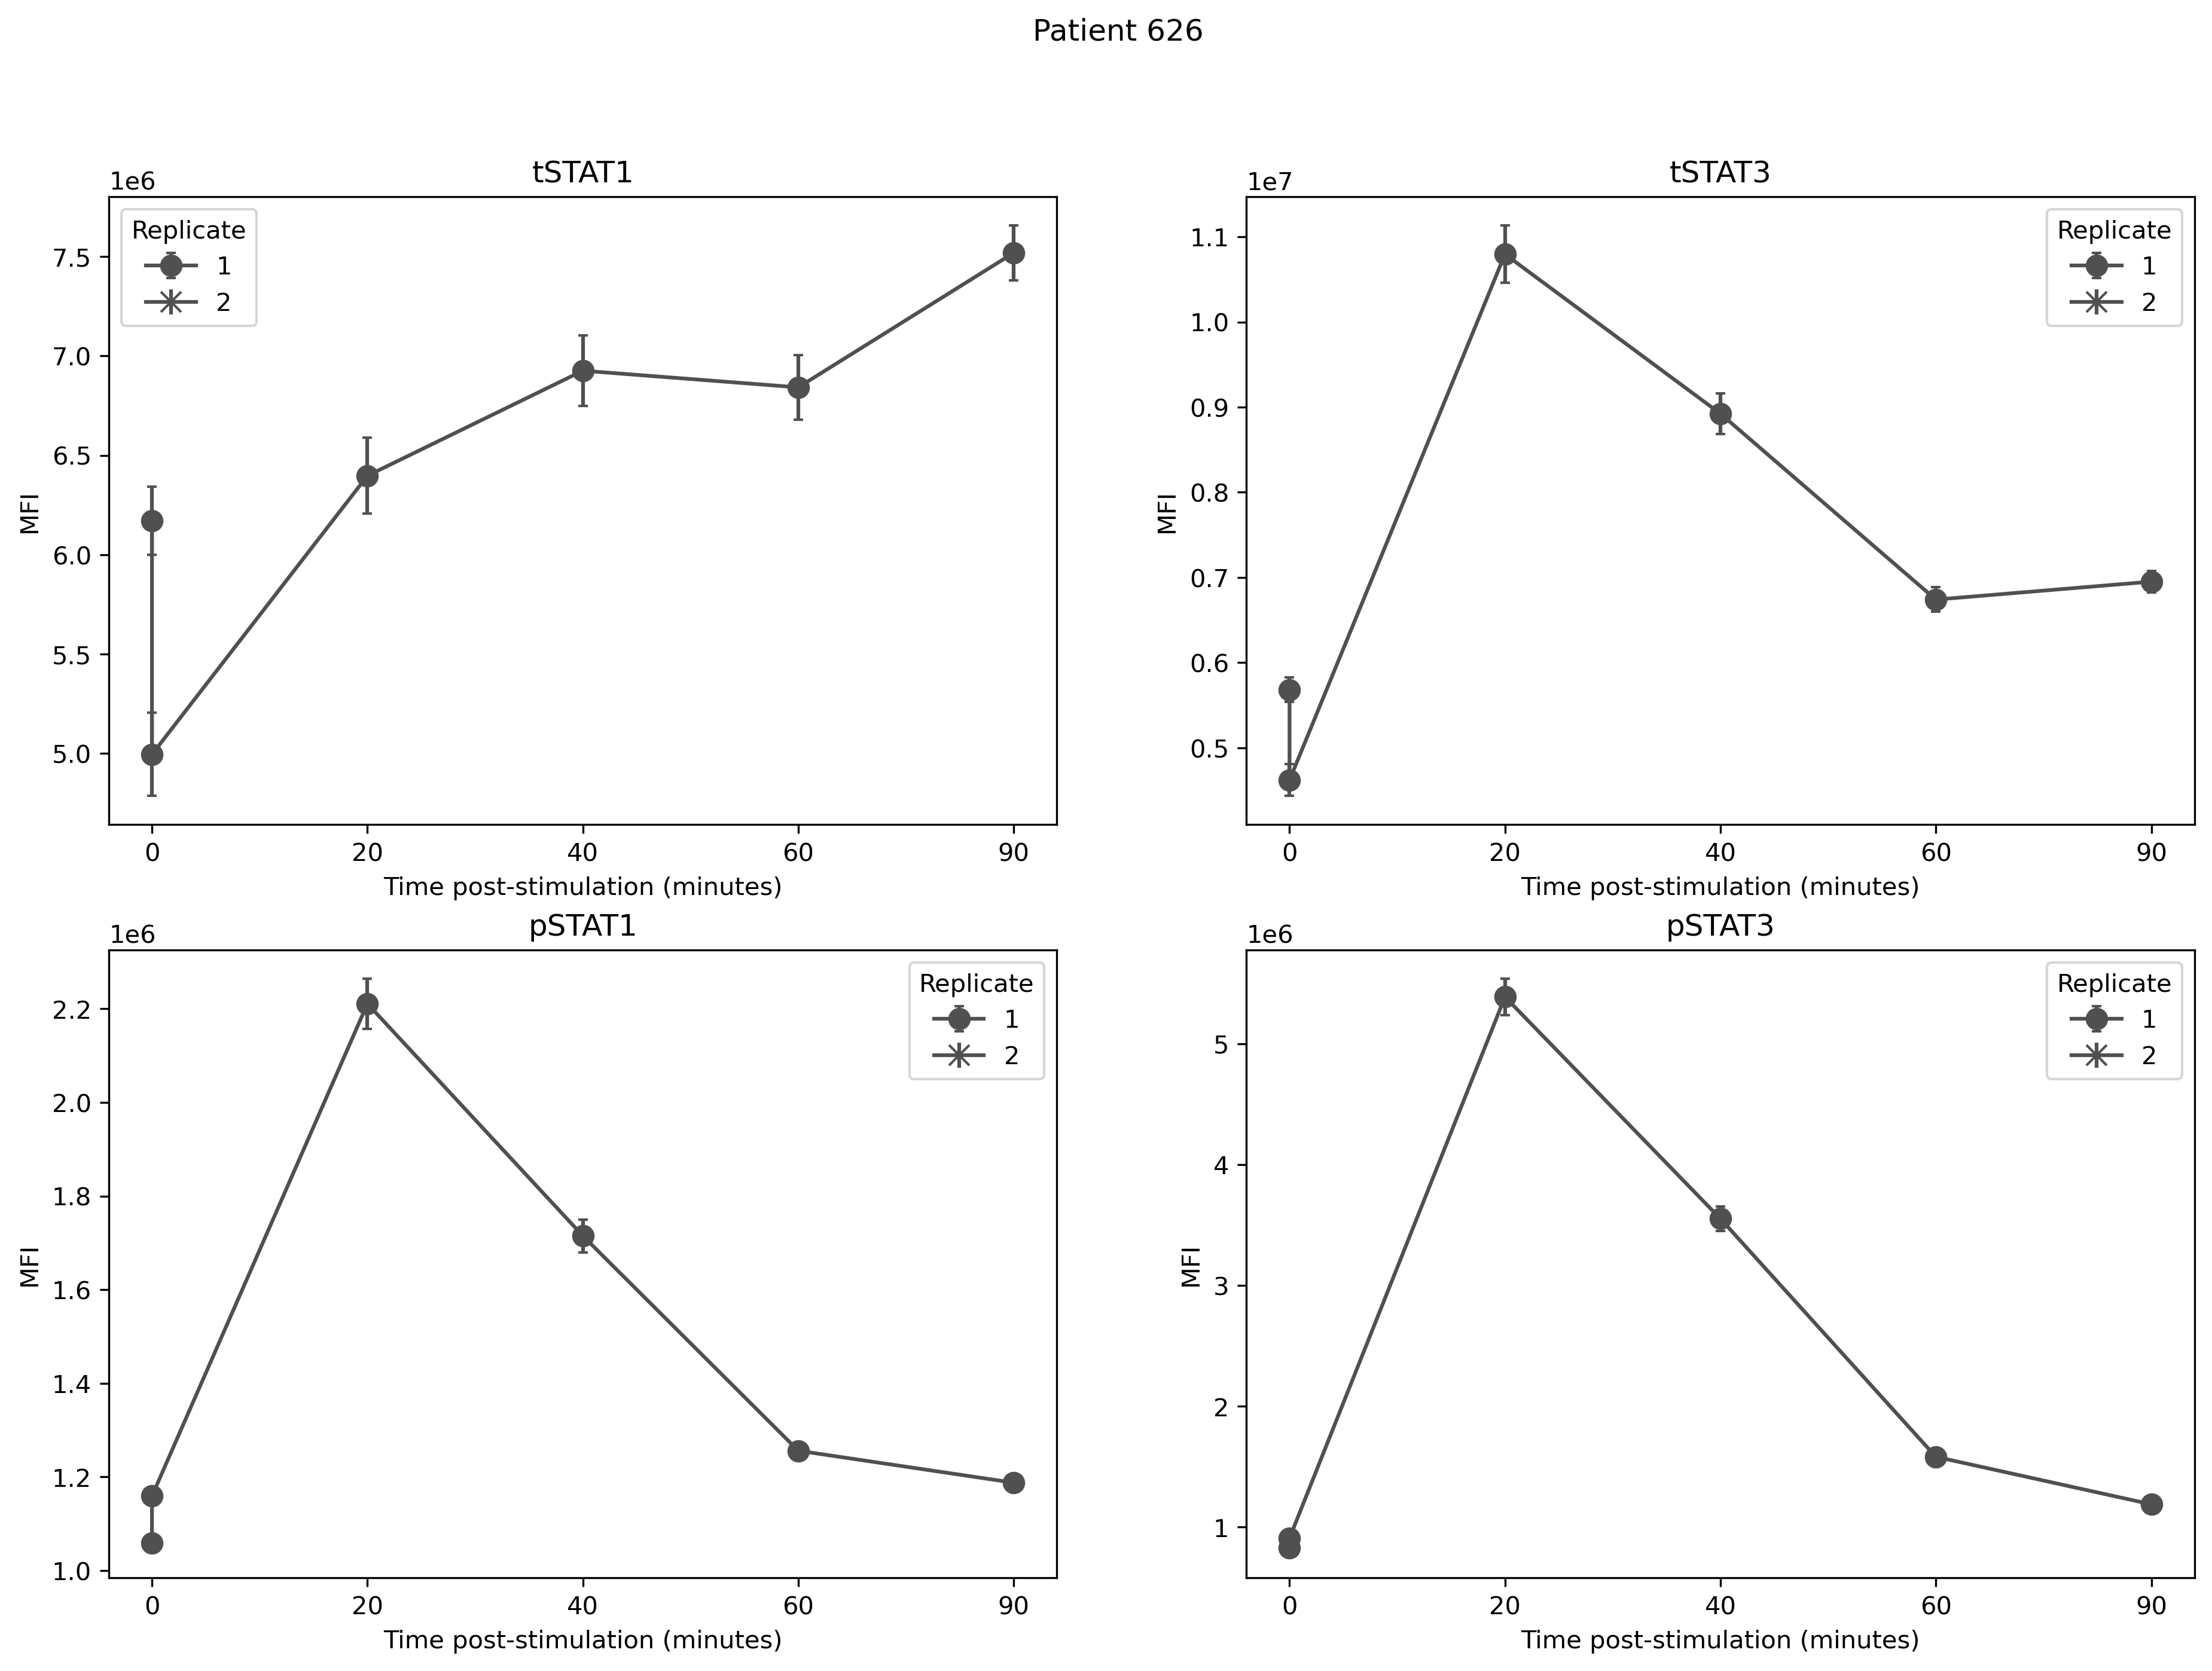

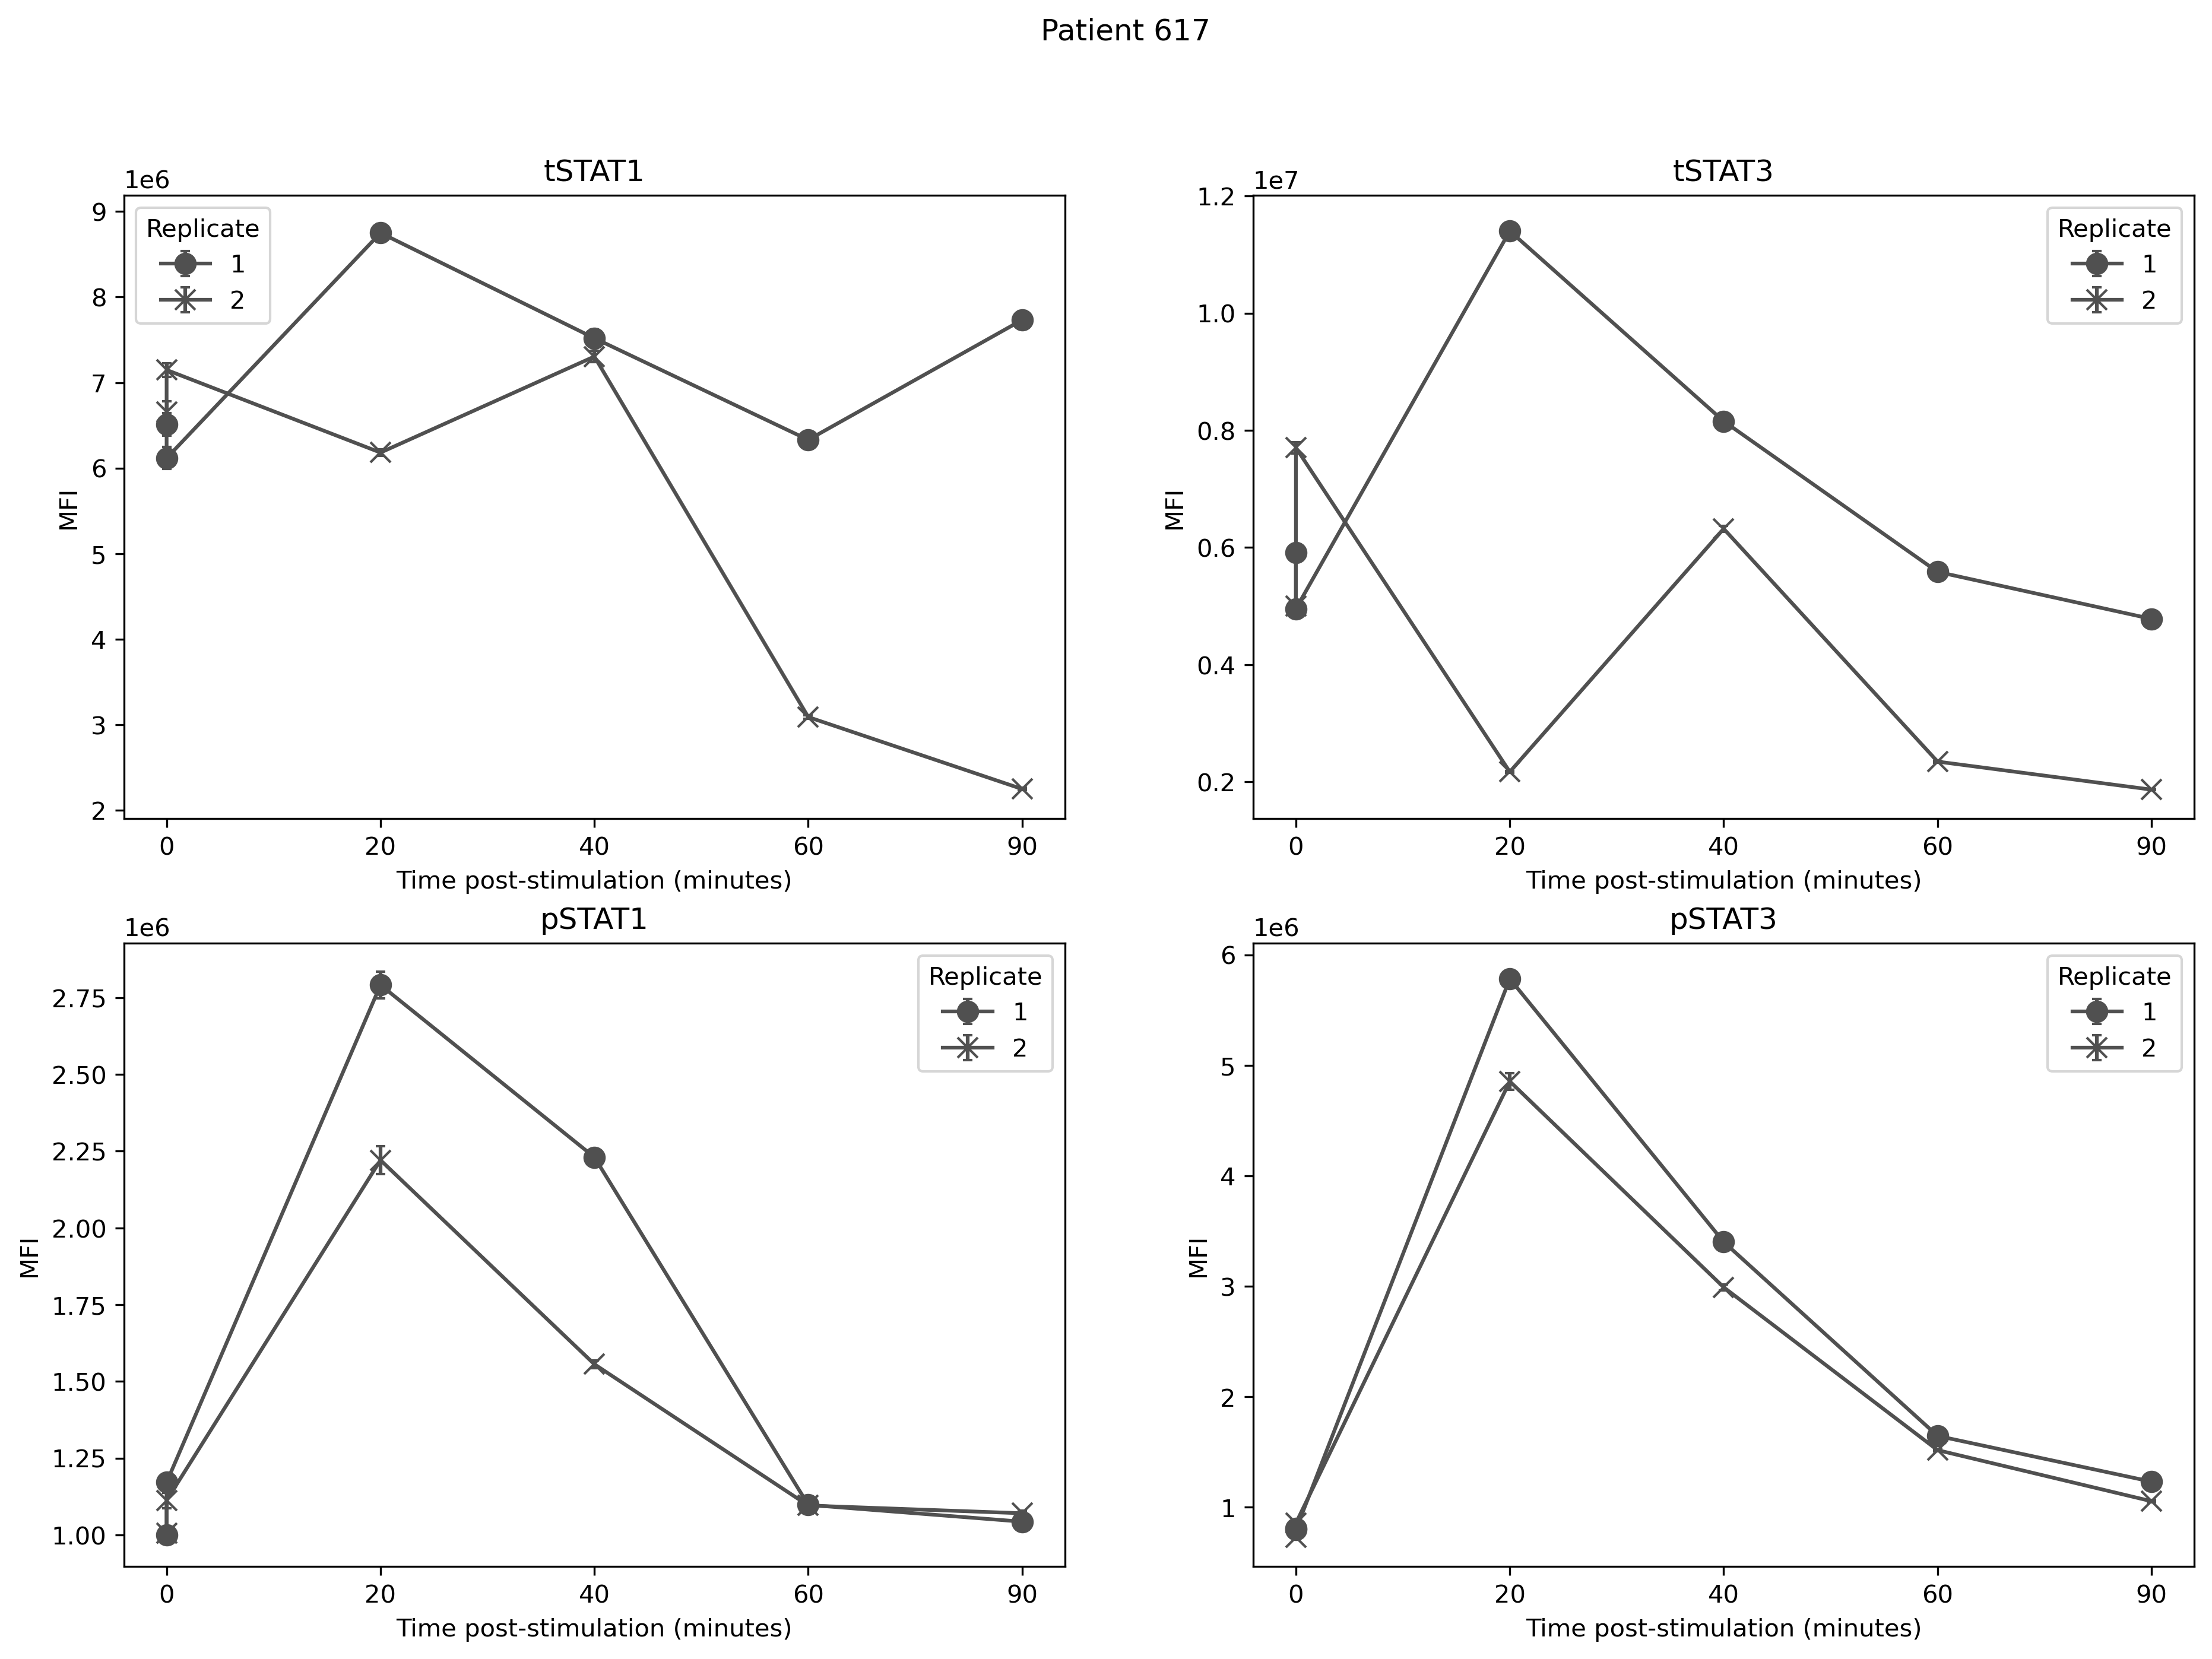

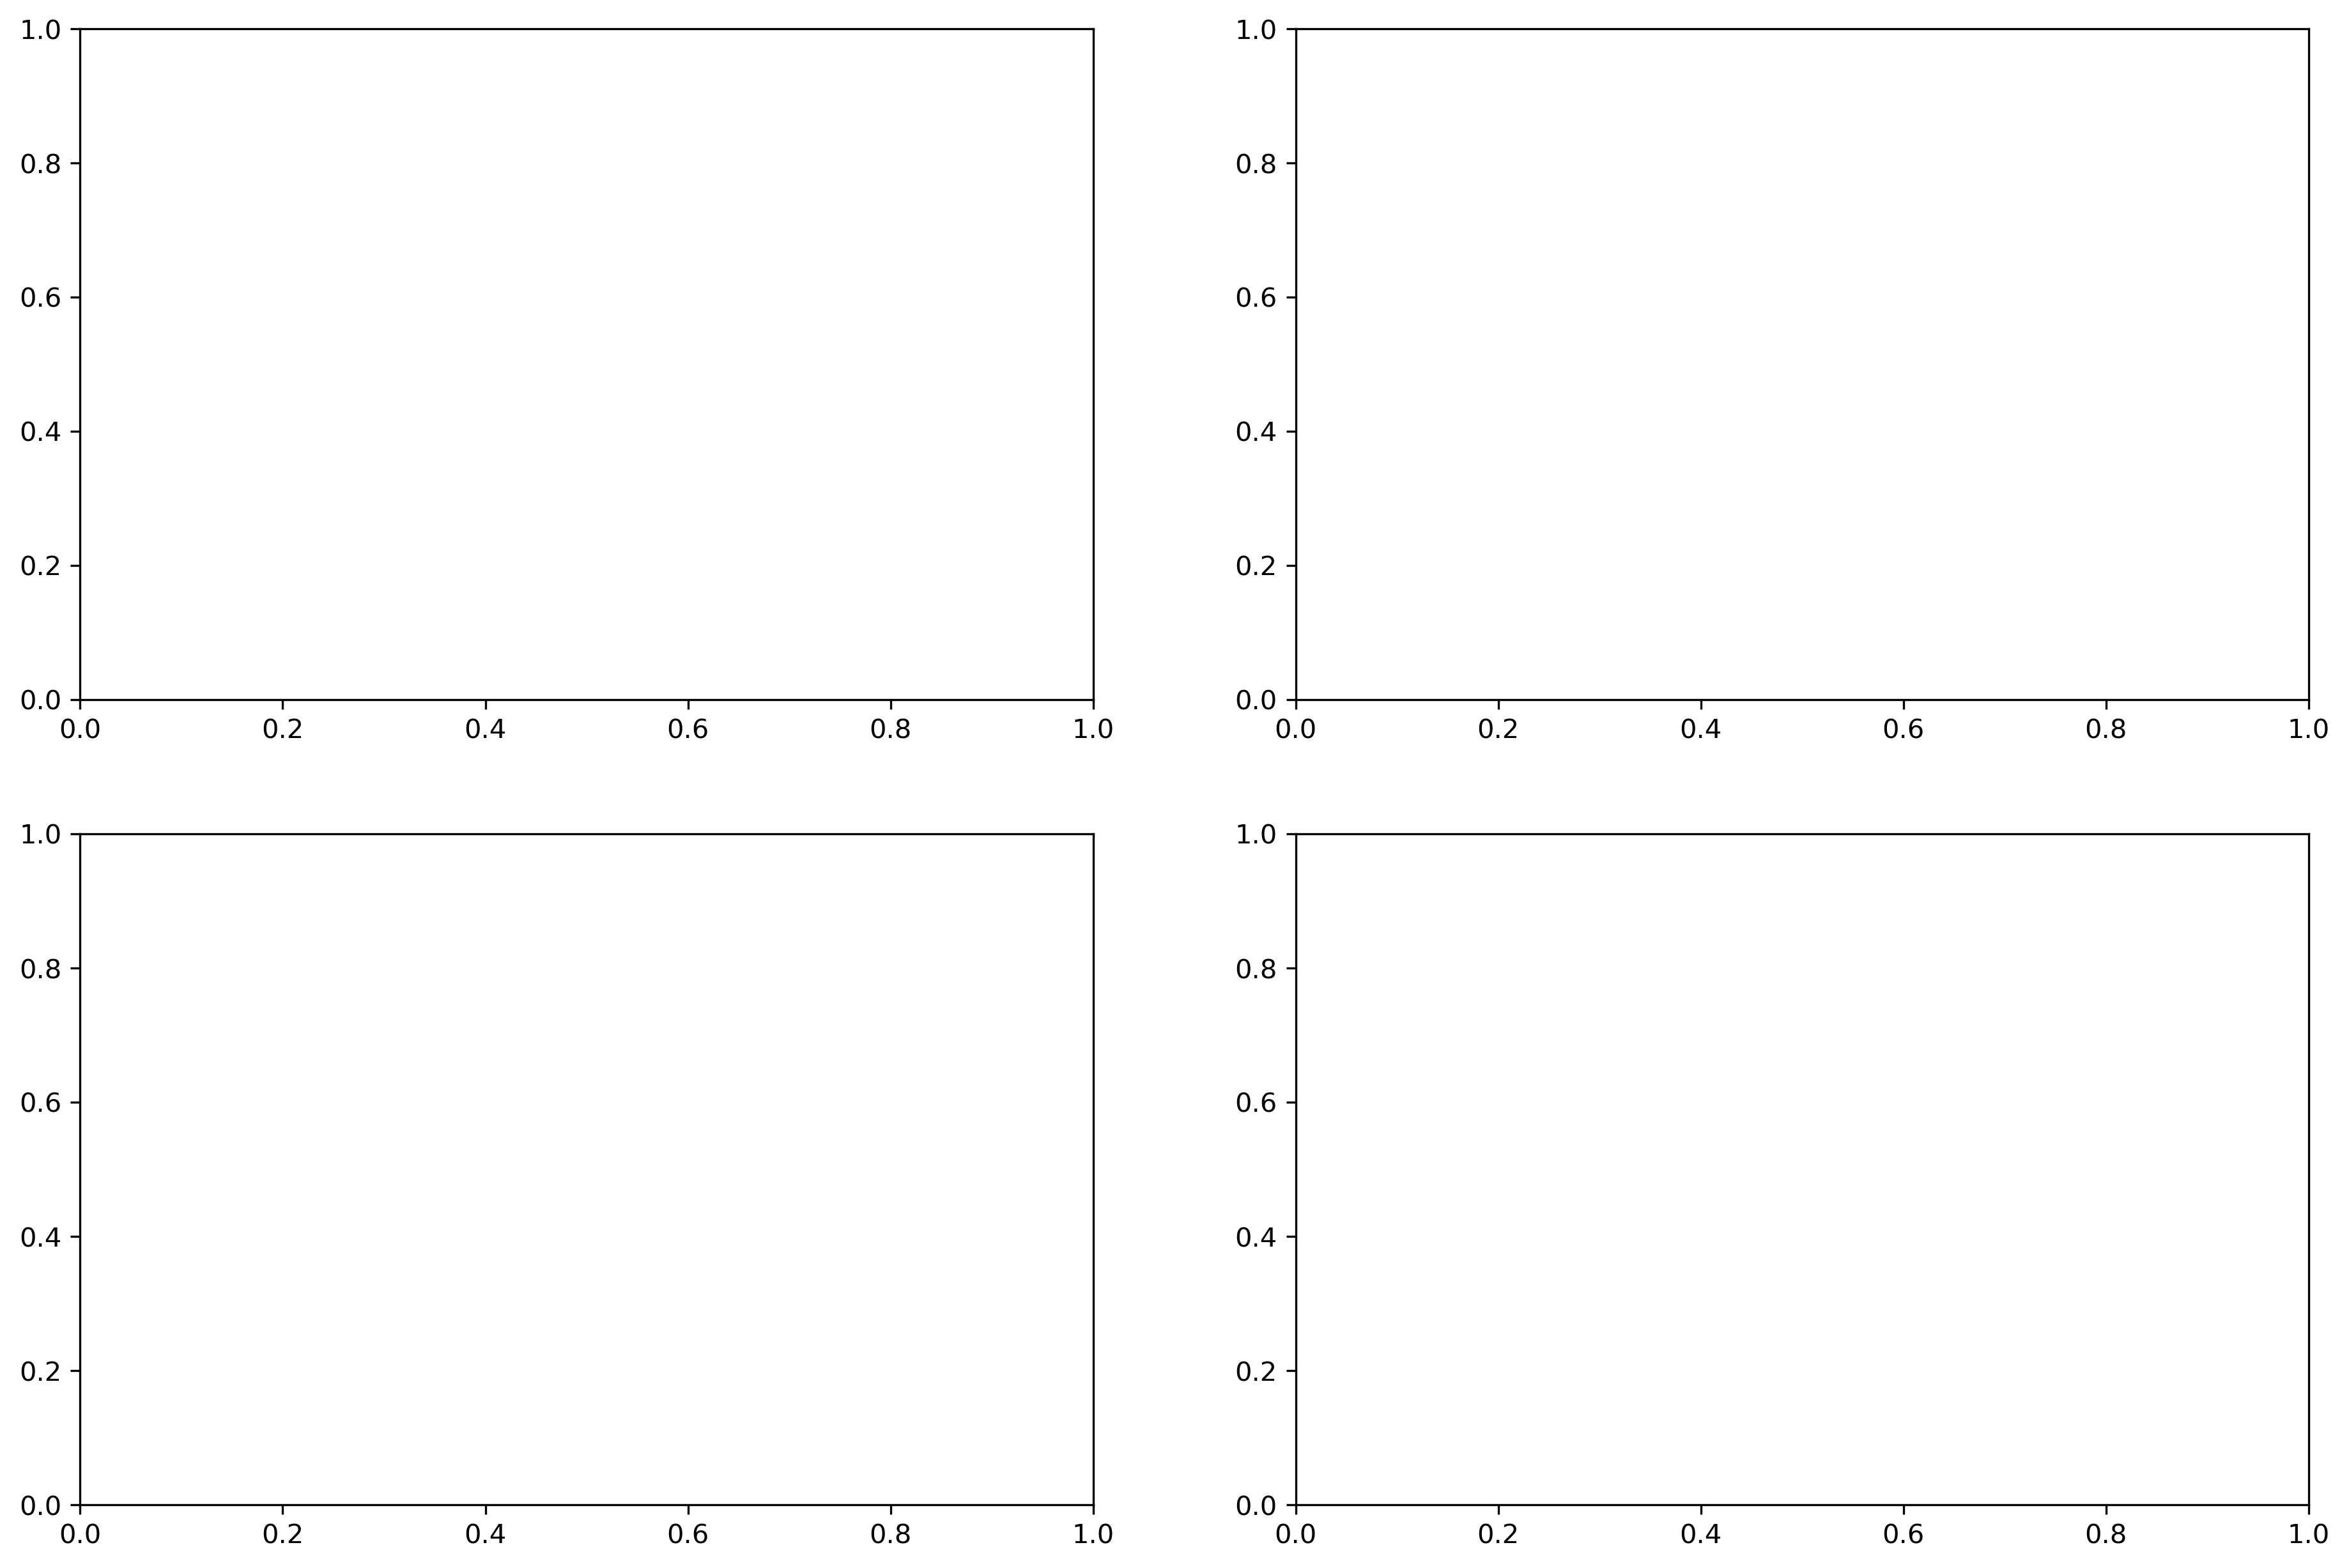

In [ ]:
manual_ylim = False

og_df = dfs[0]
dose_to_ls = {
	"10 ng/mL": "-",
	"1 ng/mL": "dotted"
}

dose_to_color = {
	"1 ng/mL": "r",
	"10 ng/mL":"b"
}

il6_to_marker = {
	"1 ng/mL": "d",
	"10 ng/mL": "x"
}

replicate_to_marker = {
	1:"o",
	2:"x"
}

ylims = [[[1e6, 6*1e6], [2*1e6, 6*1e6]],
		 [[4*1e5, 6*1e5], [0.7*1e6, 2*1e6]],
		 [[4.5*1e5, 6.5*1e5], [1.2*1e6, 2.2*1e6]]]

ms = 8 # markersize
color = "#505050"
fig1, axs1 = plt.subplots(2,2, figsize=(15,10), dpi=300)
fig2, axs2 = plt.subplots(2,2, figsize=(15,10), dpi=300)
fig3, axs3 = plt.subplots(2,2, figsize=(15,10), dpi=300)

# Select tSTAT measurement
df = og_df[(og_df["STAT"] == "tSTAT")]

for pat, cur_axs in zip(df["PatientId"].unique(), [axs1, axs2, axs3]):
	# Plot tSTATs from first scan
	stat1_ax = cur_axs[0][0]
	stat3_ax = cur_axs[0][1]
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
	stat1_ax.set_ylabel("MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Replicate")
	stat1_ax.set_title("tSTAT1")
	stat3_ax.set_ylabel("MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Replicate")
	stat3_ax.set_title("tSTAT3")
	if manual_ylim:
		stat1_ax.set_ylim(*ylims[0][0])
		stat3_ax.set_ylim(*ylims[0][1])


# Select pSTAT measurement
df = og_df[og_df["STAT"] == "pSTAT"]

for pat, cur_axs in zip(df["PatientId"].unique(), [axs1, axs2, axs3]):
	# Plot tSTATs from first scan
	stat1_ax = cur_axs[1][0]
	stat3_ax = cur_axs[1][1]
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"] == rep)]
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
	stat1_ax.set_ylabel("MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Replicate")
	stat1_ax.set_title("pSTAT1")
	stat3_ax.set_ylabel("MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Replicate")
	stat3_ax.set_title("pSTAT3")
	if manual_ylim:
		stat1_ax.set_ylim(*ylims[1][0])
		stat3_ax.set_ylim(*ylims[1][1])

id1 = df["PatientId"].unique()[0]
id2 = df["PatientId"].unique()[1]
#id3 = df["PatientId"].unique()[2]

fig1.suptitle(f"Patient {id1}")
fig2.suptitle(f"Patient {id2}");
#fig3.suptitle(f"Patient {id3}")


In [ ]:
og_df.head()

,STAT1 Mean,STAT1 SEM,STAT3 Mean,STAT3 SEM,STAT,PatientId,IL-6 Concentration,Time,Replicate
WellId,,,,,,,,,
B01,6.223765e+05,4375.022710,5.480078e+05,4274.571251,pSTAT,165,10 ng/mL,0,1
B02,6.783064e+05,6043.212530,6.108987e+05,9231.720928,pSTAT,165,10 ng/mL,0,1
B03,1.396093e+06,15607.087261,3.181581e+06,37330.287642,pSTAT,165,10 ng/mL,25,1
B04,1.523545e+06,24882.612075,3.103577e+06,44835.003231,pSTAT,165,10 ng/mL,45,1
B05,7.745966e+05,6472.676666,1.527542e+06,21935.789860,pSTAT,165,10 ng/mL,65,1


Text(0.5, 0.98, 'IFNB Stimulation (10 ng/mL) with Donor 451')

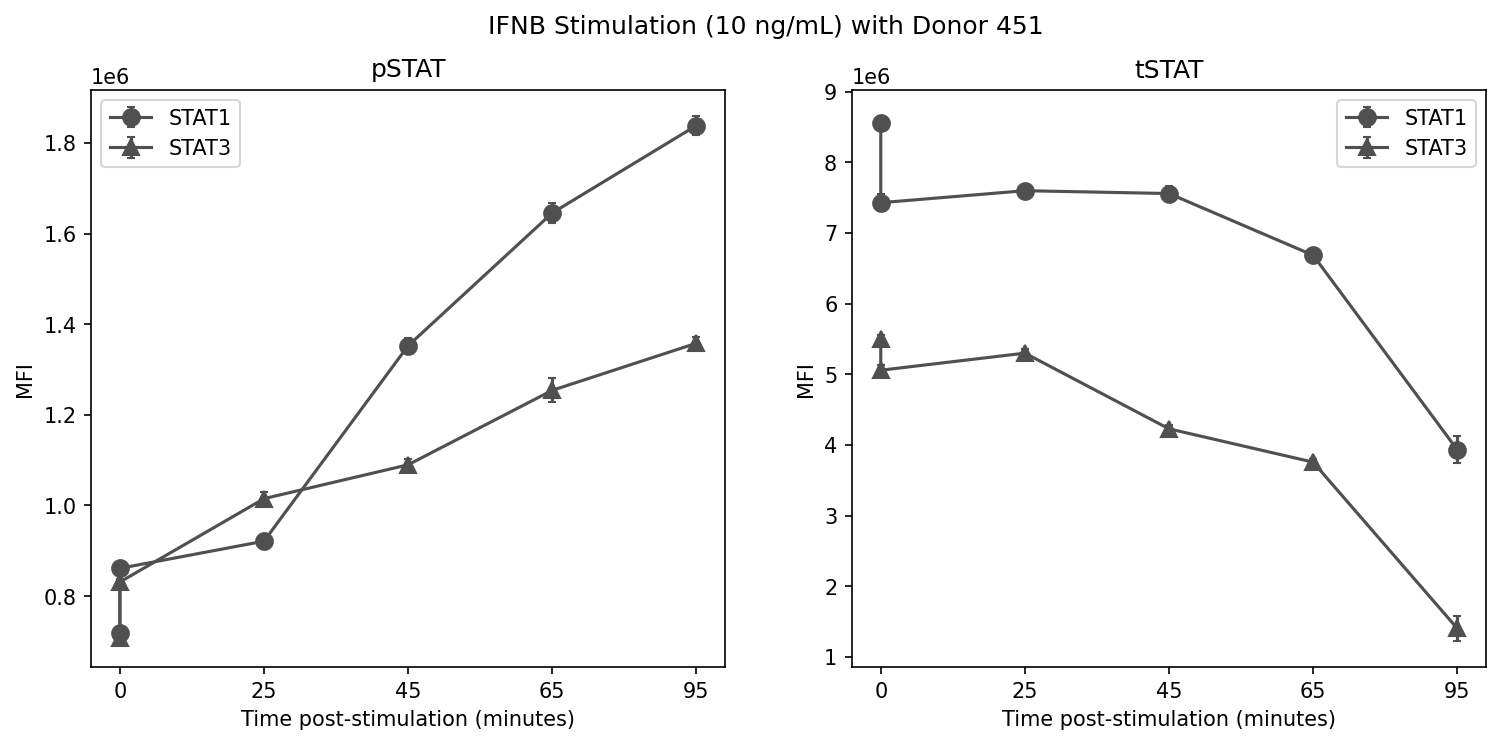

In [ ]:
ms = 8 # markersize
color = "#505050"

stat_df = og_df.loc[(og_df["PatientId"] == 4510)]

# Select pSTAT measurement
pdf = stat_df[stat_df["STAT"] == "pSTAT"]
tdf = stat_df[stat_df["STAT"] == "tSTAT"]

fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)

axs[0].errorbar(x=pdf["Time"], y=pdf["STAT1 Mean"], yerr=pdf["STAT1 SEM"],
					marker="o", ms=ms, color=color,
					ls="-", label=f"STAT1", capsize=2)
		
axs[0].errorbar(x=pdf["Time"], y=pdf["STAT3 Mean"], yerr=pdf["STAT3 SEM"],
					marker="^", ms=ms, color=color,
					ls="-", label=f"STAT3", capsize=2)

axs[0].set_ylabel("MFI")
axs[0].set_xlabel("Time post-stimulation (minutes)")
axs[0].legend()
axs[0].set_title("pSTAT")

axs[1].errorbar(x=tdf["Time"], y=tdf["STAT1 Mean"], yerr=tdf["STAT1 SEM"],
					marker="o", ms=ms, color=color,
					ls="-", label=f"STAT1", capsize=2)
		
axs[1].errorbar(x=tdf["Time"], y=tdf["STAT3 Mean"], yerr=tdf["STAT3 SEM"],
					marker="^", ms=ms, color=color,
					ls="-", label=f"STAT3", capsize=2)

axs[1].set_ylabel("MFI")
axs[1].set_xlabel("Time post-stimulation (minutes)")
axs[1].legend()
axs[1].set_title("tSTAT")

plt.suptitle("IFNB Stimulation (10 ng/mL) with Donor 451")